In this file, two different machine learning models will be developed and trained to predict machine failure based on different feautures.

The dataset is taken from https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset and will include following features:

- Air temperature [K]

- Process temperature [K]

- Rotational speed [RPM]

- Torque [Nm]

- Tool wear [min]

The target variable will be 0 (no failure) and 1 (failure) to indicate the prediction of machine failure.

The chosen machine learning models will be logistic regression and random forest.

We start by importing the necessary libraries and loading the data. We will be using pandas for data handling, seaborn and matplotlib for visualizations and sklearn for the machine learning models

In [209]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression  
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv"
data = pd.read_csv(url)

Now we check the data for null values. If any values are null, we delete the entire row.

In [210]:
print("Checking for null values...")
print(data.isnull().sum())  # Prints the count of null values in each column
data.dropna(inplace=True)  # Drop rows with null values
print("After removing null values, data shape:", data.shape)

Checking for null values...
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64
After removing null values, data shape: (10000, 14)


We then plot a heatmap so get a visualization of the correlation between the 5 different features that will be used later in our models.

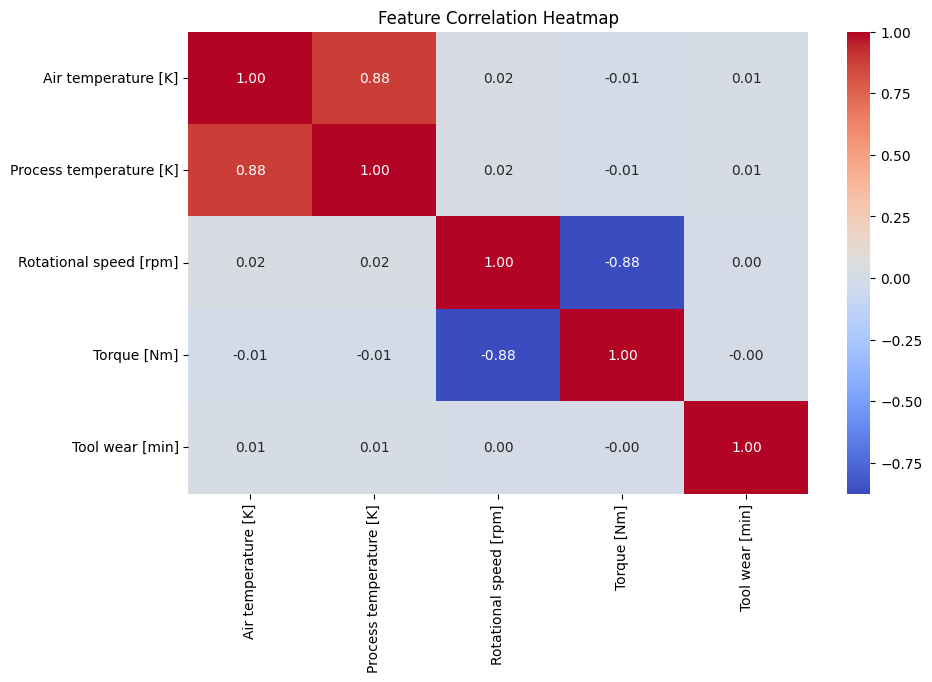

In [211]:
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 
            'Torque [Nm]', 'Tool wear [min]']

numeric_data = data[features]

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()



We now split the data for training/test and choose the features we want, with a training size of 20% and test size of 80%

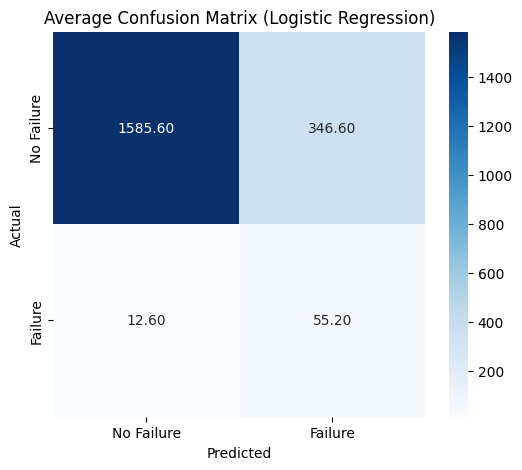

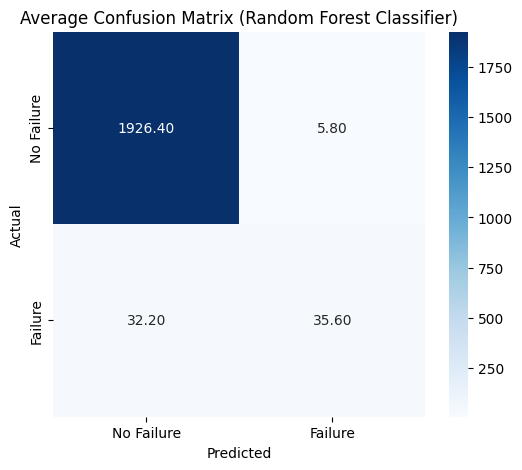

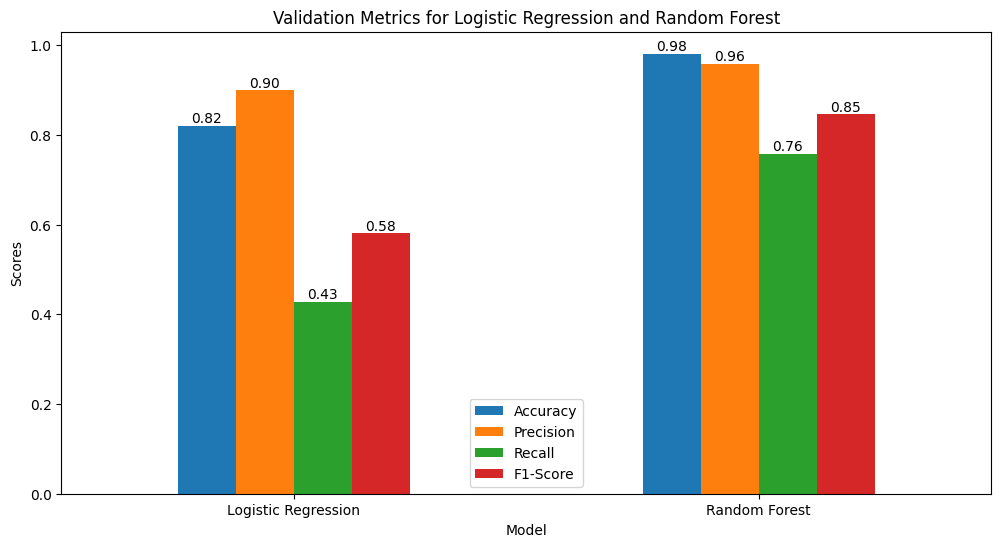

In [212]:
# Initialize accumulators for confusion matrices
conf_matrix_accumLR = np.zeros((2, 2))
conf_matrix_accumRFC = np.zeros((2, 2))

for train_idx, test_idx in skf.split(X, y):
    # Split the data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Logistic Regression
    modelLR = LogisticRegression(class_weight='balanced', random_state=42)
    modelLR.fit(X_train, y_train)
    y_predLR = modelLR.predict(X_test)
    
    # Logistic Regression Confusion Matrix
    conf_matrixLR = confusion_matrix(y_test, y_predLR)
    conf_matrix_accumLR += conf_matrixLR  # Add the confusion matrix for this fold
    
    # Random Forest Classifier
    modelRFC = RandomForestClassifier(class_weight='balanced', random_state=42)
    modelRFC.fit(X_train, y_train)
    y_predRFC = modelRFC.predict(X_test)
    
    # Random Forest Confusion Matrix
    conf_matrixRFC = confusion_matrix(y_test, y_predRFC)
    conf_matrix_accumRFC += conf_matrixRFC  # Add the confusion matrix for this fold

# Average confusion matrices across folds
avg_conf_matrixLR = conf_matrix_accumLR / skf.n_splits
avg_conf_matrixRFC = conf_matrix_accumRFC / skf.n_splits

# Plot average confusion matrix for Logistic Regression
plt.figure(figsize=(6, 5))
sns.heatmap(avg_conf_matrixLR, annot=True, fmt=".2f", cmap="Blues", xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Average Confusion Matrix (Logistic Regression)")
plt.show()

# Plot average confusion matrix for Random Forest Classifier
plt.figure(figsize=(6, 5))
sns.heatmap(avg_conf_matrixRFC, annot=True, fmt=".2f", cmap="Blues", xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Average Confusion Matrix (Random Forest Classifier)")
plt.show()

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   

# Prepare the validation metrics
validation_metrics = {
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [
        sum(accum_metrics["Logistic Regression"]["Accuracy"]) / len(accum_metrics["Logistic Regression"]["Accuracy"]),
        sum(accum_metrics["Random Forest"]["Accuracy"]) / len(accum_metrics["Random Forest"]["Accuracy"]),
    ],
    "Precision": [
        sum(accum_metrics["Logistic Regression"]["ROC AUC"]) / len(accum_metrics["Logistic Regression"]["ROC AUC"]),
        sum(accum_metrics["Random Forest"]["ROC AUC"]) / len(accum_metrics["Random Forest"]["ROC AUC"]),
    ],
    "Recall": [
        sum(accum_metrics["Logistic Regression"]["Average Precision"]) / len(accum_metrics["Logistic Regression"]["Average Precision"]),
        sum(accum_metrics["Random Forest"]["Average Precision"]) / len(accum_metrics["Random Forest"]["Average Precision"]),
    ],
    "F1-Score": [
        2 * (
            sum(accum_metrics["Logistic Regression"]["ROC AUC"]) / len(accum_metrics["Logistic Regression"]["ROC AUC"])
            * sum(accum_metrics["Logistic Regression"]["Average Precision"]) / len(accum_metrics["Logistic Regression"]["Average Precision"])
        ) / (
            sum(accum_metrics["Logistic Regression"]["ROC AUC"]) / len(accum_metrics["Logistic Regression"]["ROC AUC"])
            + sum(accum_metrics["Logistic Regression"]["Average Precision"]) / len(accum_metrics["Logistic Regression"]["Average Precision"])
        ),
        2 * (
            sum(accum_metrics["Random Forest"]["ROC AUC"]) / len(accum_metrics["Random Forest"]["ROC AUC"])
            * sum(accum_metrics["Random Forest"]["Average Precision"]) / len(accum_metrics["Random Forest"]["Average Precision"])
        ) / (
            sum(accum_metrics["Random Forest"]["ROC AUC"]) / len(accum_metrics["Random Forest"]["ROC AUC"])
            + sum(accum_metrics["Random Forest"]["Average Precision"]) / len(accum_metrics["Random Forest"]["Average Precision"])
        ),
    ],
}

# Convert the validation metrics dictionary into a DataFrame
validation_metrics_df = pd.DataFrame(validation_metrics)

# Plot a bar chart for the validation metrics
ax = validation_metrics_df.set_index("Model").plot(kind="bar", figsize=(12, 6), color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"])
plt.title("Validation Metrics for Logistic Regression and Random Forest")
plt.ylabel("Scores")
plt.xticks(rotation=0)
plt.legend(loc="best")

# Annotate the bar chart with numeric values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2, p.get_height()),
                xytext=(0, 5), textcoords="offset points", ha="center", va="center")

plt.show()


We plot the stratitied k-folds of our dataset

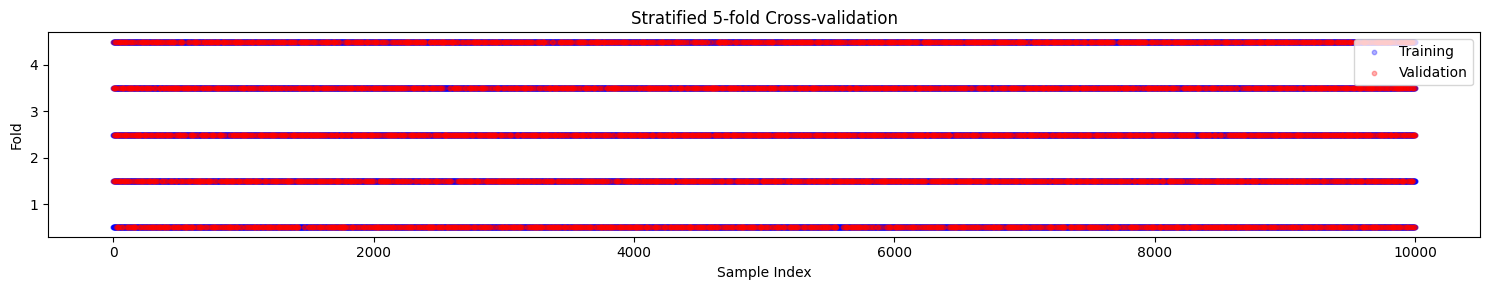


Class distribution in each fold:
Fold 1 validation set class distribution: [1933   67]
Fold 2 validation set class distribution: [1932   68]
Fold 3 validation set class distribution: [1932   68]
Fold 4 validation set class distribution: [1932   68]
Fold 5 validation set class distribution: [1932   68]


In [213]:
def plot_kfold(X, n_splits, stratified=True):
    if stratified:
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        title = f'Stratified {n_splits}-fold Cross-validation'

    
    fig, ax = plt.subplots(figsize=(15, 3))
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        ax.scatter(train_idx, [fold + 0.5] * len(train_idx), 
                  c='blue', alpha=0.3, s=10, label='Training' if fold == 0 else "")
        ax.scatter(val_idx, [fold + 0.5] * len(val_idx), 
                  c='red', alpha=0.3, s=10, label='Validation' if fold == 0 else "")
    
    ax.set_title(title)
    ax.set_ylabel('Fold')
    ax.set_xlabel('Sample Index')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot stratified K-fold
plot_kfold(X, n_splits=5, stratified=True)

# Print class distribution in each fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\nClass distribution in each fold:")
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1} validation set class distribution:", np.bincount(y[val_idx]))

We can now use a model to train on the data. We train a model both for the logistic regression and random forest

In [214]:
modelLR = LogisticRegression(class_weight='balanced', random_state=42)
modelLR.fit(X_train, y_train)

modelRFC = RandomForestClassifier(class_weight='balanced', random_state=42)
modelRFC.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

We can now make a prediction on the test set for a target value for both models

In [215]:
#y_predLR = modelLR.predict(X_test)

#y_predRFC = modelRFC.predict(X_test)

Now we want to evaluate the performance of the models. We make a confusion matrix for both the models and visualize it

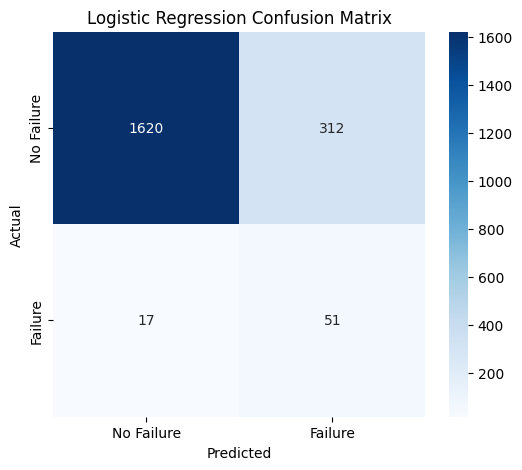

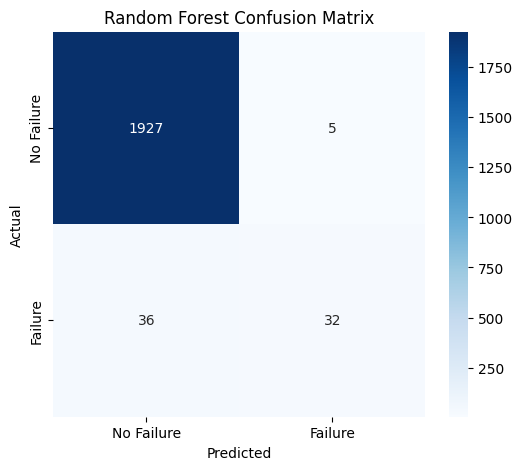

In [216]:
# Confusion Matrix for Logistic Regression
conf_matrixLR = confusion_matrix(y_test, y_predLR)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrixLR, annot=True, fmt='d', cmap='Blues', xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# Confusion Matrix for Random Forest Classifier
conf_matrixRFC = confusion_matrix(y_test, y_predRFC)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrixRFC, annot=True, fmt='d', cmap='Blues', xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()


We then make a classification report to see the different metrics for evaluating the models. 

In [217]:
# Classification Report for Logistic Regression
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_predLR))

# Classification Report for Random Forest Classifier
print("\nClassification Report for Random Forest Classifier:")
print(classification_report(y_test, y_predRFC))


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      1932
           1       0.14      0.75      0.24        68

    accuracy                           0.84      2000
   macro avg       0.57      0.79      0.57      2000
weighted avg       0.96      0.84      0.88      2000


Classification Report for Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.86      0.47      0.61        68

    accuracy                           0.98      2000
   macro avg       0.92      0.73      0.80      2000
weighted avg       0.98      0.98      0.98      2000



We now store the metrics for both models in a dictionary and make a barplot to visualize the performance of both models agaisnt eachother.


Model Comparison:
                      Model  Accuracy  Precision (class 1)  Recall (class 1)  \
0       Logistic Regression    0.8355             0.140496          0.750000   
1  Random Forest Classifier    0.9795             0.864865          0.470588   

   F1-Score (class 1)  
0            0.236659  
1            0.609524  


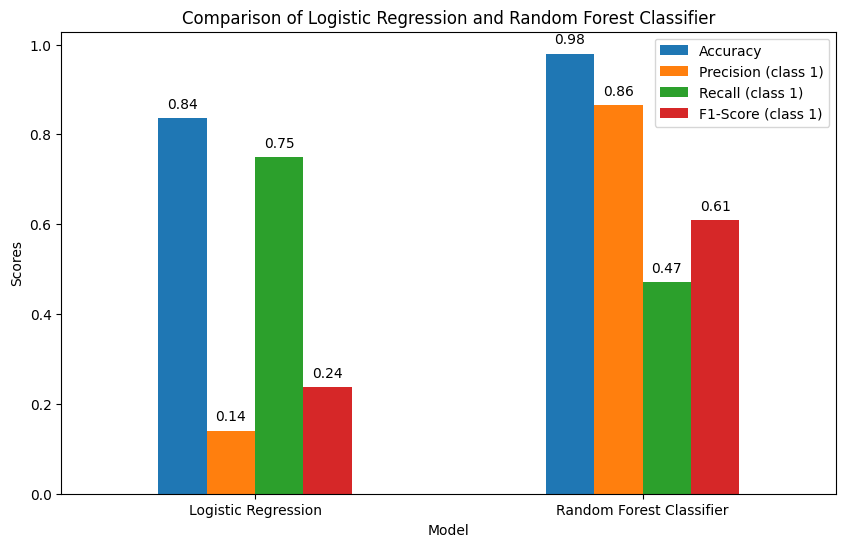

In [218]:
# Create a dictionary to store metrics for both models
metrics = {
    "Model": ["Logistic Regression", "Random Forest Classifier"],
    "Accuracy": [accuracy_score(y_test, y_predLR), accuracy_score(y_test, y_predRFC)],
    "Precision (class 1)": [classification_report(y_test, y_predLR, output_dict=True)["1"]["precision"],
                            classification_report(y_test, y_predRFC, output_dict=True)["1"]["precision"]],
    "Recall (class 1)": [classification_report(y_test, y_predLR, output_dict=True)["1"]["recall"],
                         classification_report(y_test, y_predRFC, output_dict=True)["1"]["recall"]],
    "F1-Score (class 1)": [classification_report(y_test, y_predLR, output_dict=True)["1"]["f1-score"],
                           classification_report(y_test, y_predRFC, output_dict=True)["1"]["f1-score"]],
}

# Convert metrics dictionary to DataFrame for easy comparison
metrics_df = pd.DataFrame(metrics)

print("\nModel Comparison:")
print(metrics_df)

# Visualize the comparison in a bar plot
ax = metrics_df.set_index('Model').plot(kind='bar', figsize=(10, 6), color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])

# Add values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                xytext=(0, 10), textcoords='offset points', ha='center', va='center')

plt.title("Comparison of Logistic Regression and Random Forest Classifier")
plt.ylabel("Scores")
plt.xticks(rotation=0)
plt.show()

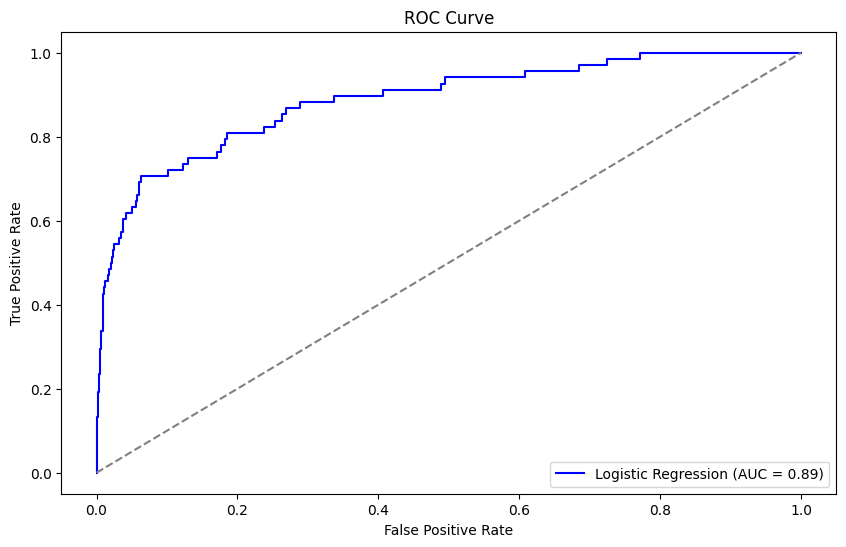

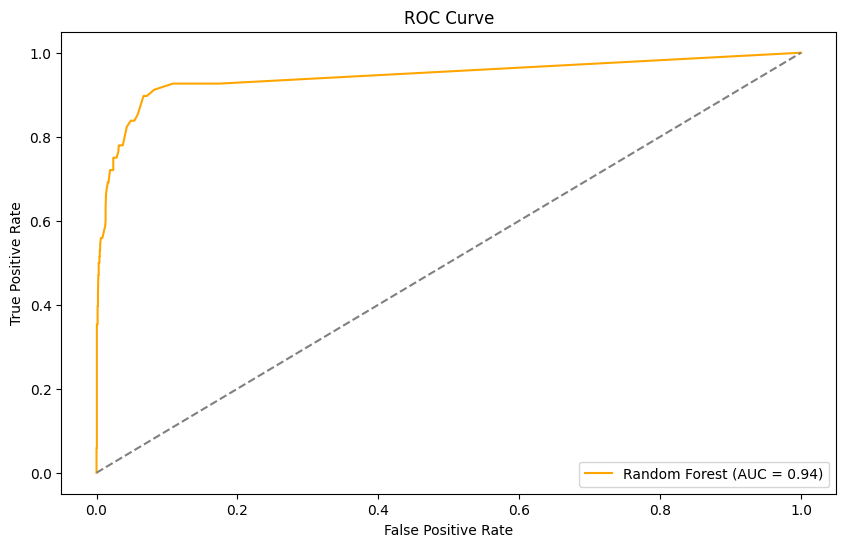

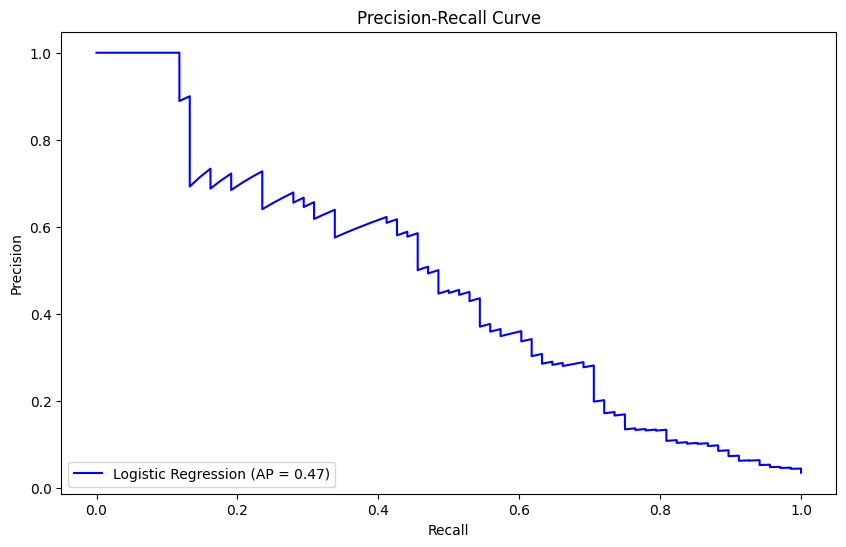

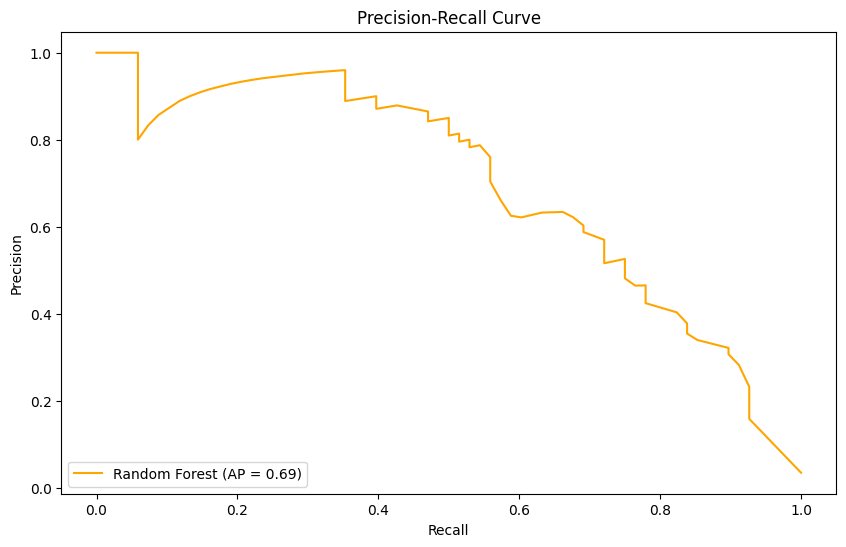

In [219]:
# ROC Curve for Logistic Regression
fprLR, tprLR, thresholdsLR = roc_curve(y_test, y_pred_probaLR)
roc_aucLR = auc(fprLR, tprLR)

plt.figure(figsize=(10, 6))
plt.plot(fprLR, tprLR, label=f'Logistic Regression (AUC = {roc_aucLR:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# ROC Curve for Random Forest Classifier
fprRFC, tprRFC, thresholdsRFC = roc_curve(y_test, y_pred_probaRFC)
roc_aucRFC = auc(fprRFC, tprRFC)

plt.figure(figsize=(10, 6))
plt.plot(fprRFC, tprRFC, label=f'Random Forest (AUC = {roc_aucRFC:.2f})', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# PR Curve for Logistic Regression
precisionLR, recallLR, thresholdsPRLR = precision_recall_curve(y_test, y_pred_probaLR)
avg_precisionLR = average_precision_score(y_test, y_pred_probaLR)

plt.figure(figsize=(10, 6))
plt.plot(recallLR, precisionLR, label=f'Logistic Regression (AP = {avg_precisionLR:.2f})', color='blue')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

# PR Curve for Random Forest Classifier
precisionRFC, recallRFC, thresholdsPRRFC = precision_recall_curve(y_test, y_pred_probaRFC)
avg_precisionRFC = average_precision_score(y_test, y_pred_probaRFC)

plt.figure(figsize=(10, 6))
plt.plot(recallRFC, precisionRFC, label=f'Random Forest (AP = {avg_precisionRFC:.2f})', color='orange')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()